In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, sys
from multiprocessing import Pool

import utils

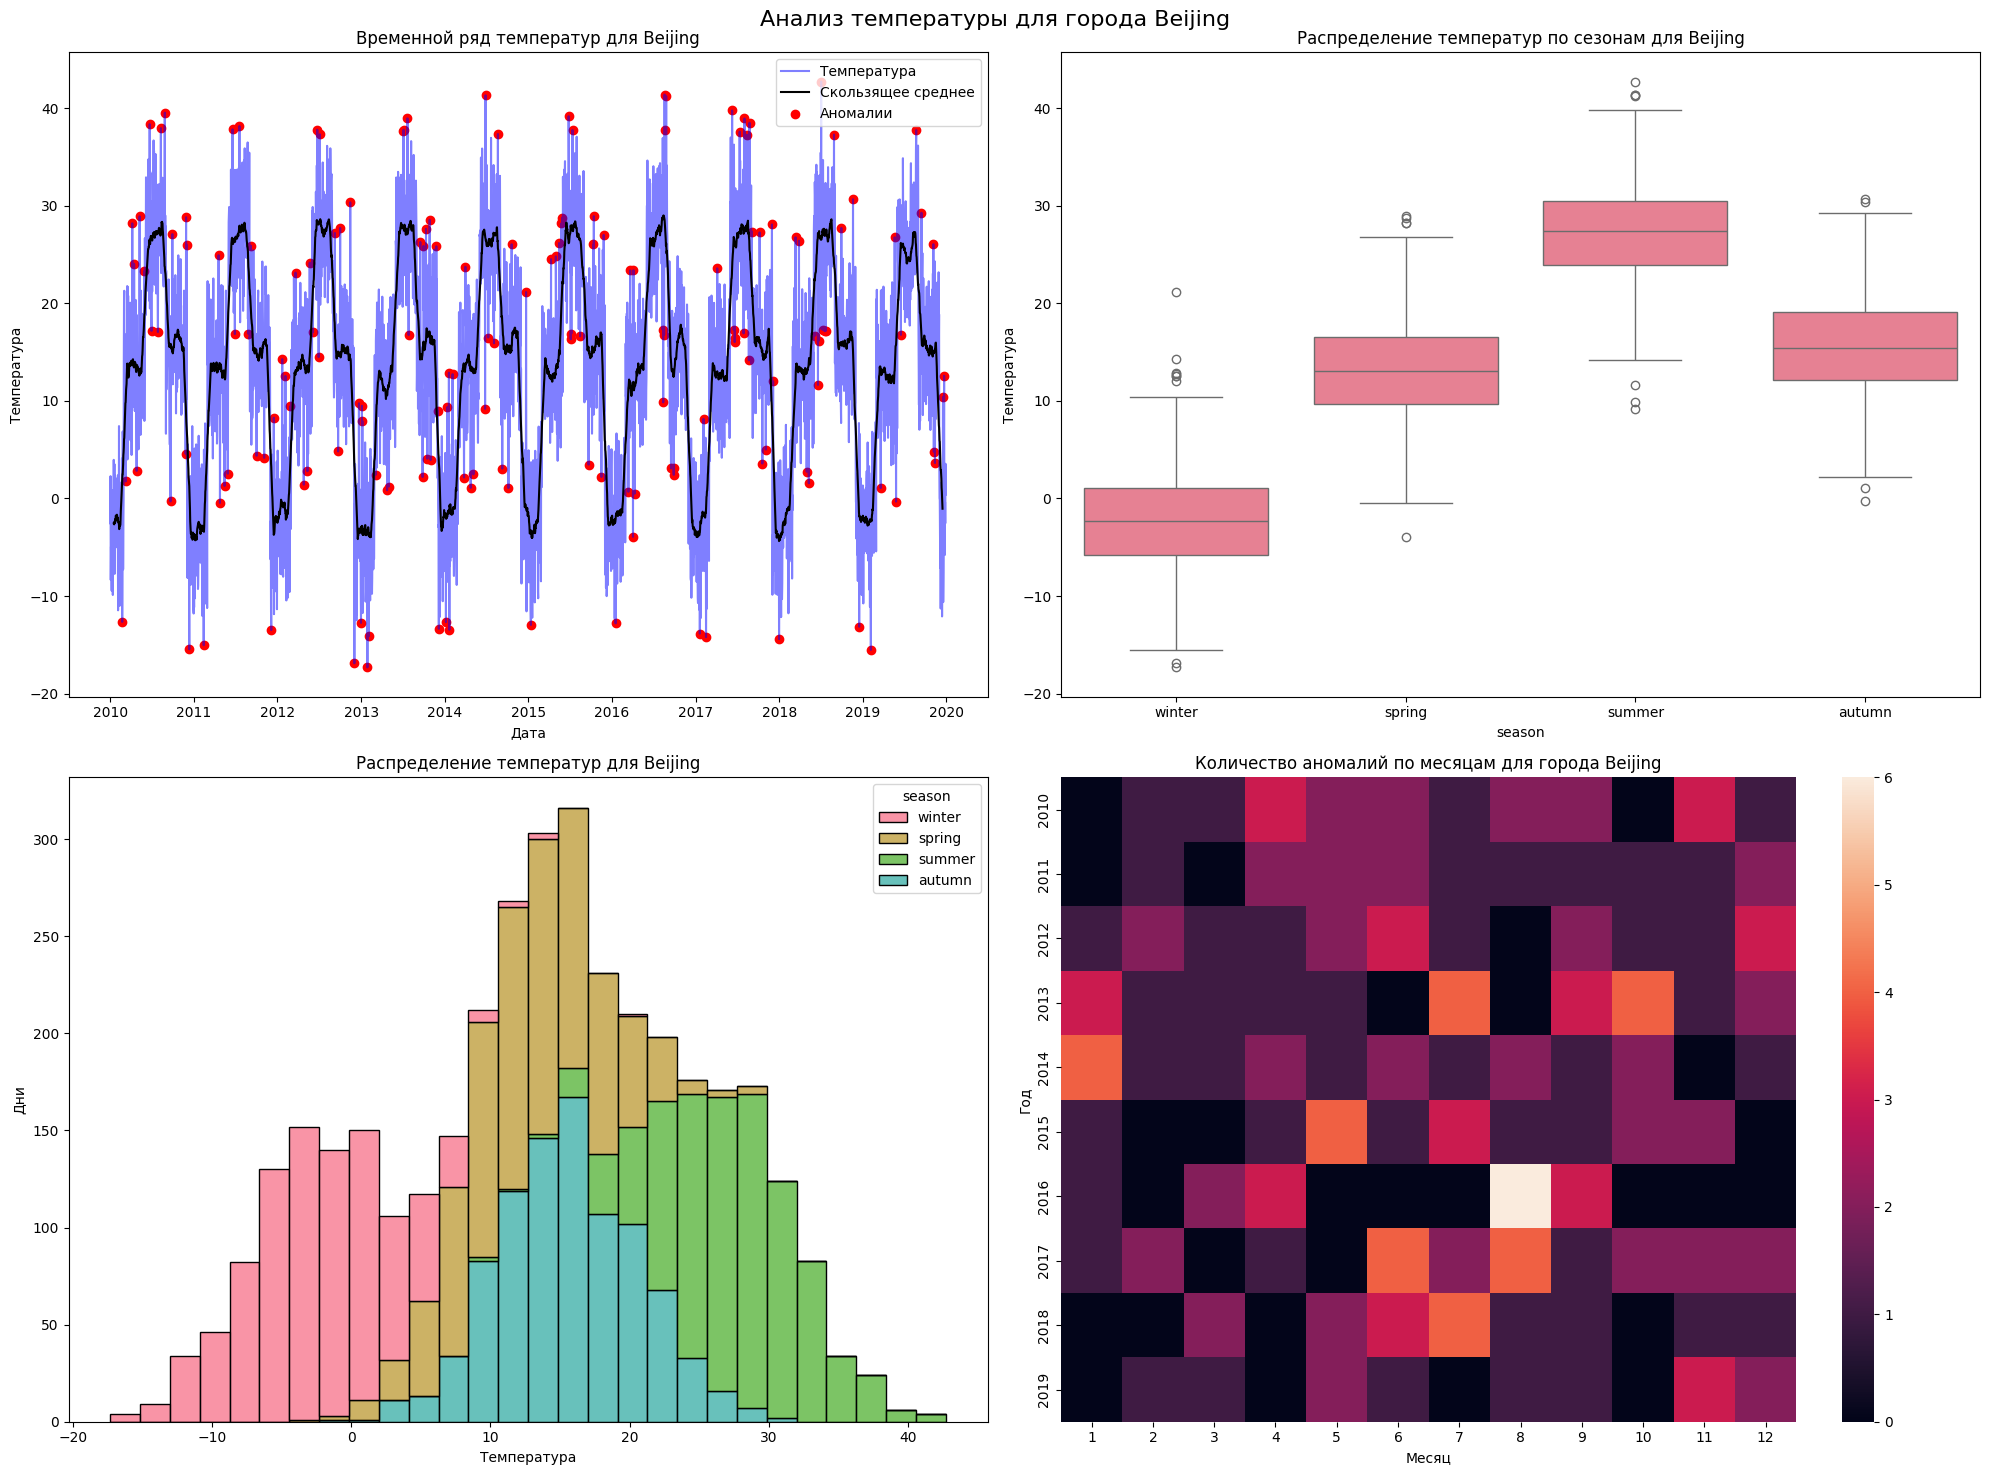


Статистика по сезонам для города Beijing:
       temperature      
              mean   std
season                  
autumn       15.58  5.05
spring       13.08  5.03
summer       27.22  4.95
winter       -2.32  5.13

Общее количество аномалий: 168

Процент аномальных дней по сезонам:
        sum  count  percentage
season                        
autumn   42    910        4.62
spring   39    920        4.24
summer   53    920        5.76
winter   34    900        3.78


In [8]:
plt.style.use('seaborn-v0_8-dark-palette')
sns.set_palette("husl")

df = pd.read_csv('temperature_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])


# Анализ всех городов
results = await utils.analyze_all_cities_temperature(df)

cities = df['city'].unique()

# Один город для подробного анализа
city = cities[7]
city_results = results[city]
city_data = city_results.data
seasonal_stats = city_results.seasonal_stats


fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle(f'Анализ температуры для города {city}', fontsize=16)


utils.plot_temperature_time_series(city_data, city, ax=axes[0, 0])
utils.plot_seasonal_boxplot(city_data, city, ax=axes[0, 1])
utils.plot_temperature_distribution(city_data, city, ax=axes[1, 0])
utils.plot_anomalies_heatmap(city_data, city, ax=axes[1, 1])

plt.tight_layout()
plt.show()


print(f"\nСтатистика по сезонам для города {city}:")
print(seasonal_stats)

print(f"\nОбщее количество аномалий: {city_data['is_anomaly'].sum()}")
print("\nПроцент аномальных дней по сезонам:")

seasonal_anomalies = city_data.groupby('season')['is_anomaly'].agg(['sum', 'count'])
seasonal_anomalies['percentage'] = (seasonal_anomalies['sum'] / seasonal_anomalies['count'] * 100).round(2)
print(seasonal_anomalies)

Сравнение параллельного и последовательного анализа

In [9]:
def analyze_temperature_data(df, city):
    """Результаты анализа для города"""
    city_data = df[df['city'] == city].copy()
    city_data['rolling_mean'] = (
        city_data['temperature']
        .rolling(window=30, center=True)
        .mean()
    )

    seasonal_stats = city_data.groupby('season').agg({
        'temperature': ['mean', 'std']
    }).round(2)

    for season in city_data['season'].unique():
        season_data = seasonal_stats.loc[season]
        mean = season_data[('temperature', 'mean')]
        std = season_data[('temperature', 'std')]

        season_mask = city_data['season'] == season
        city_data.loc[season_mask, 'is_anomaly'] = (
            (city_data.loc[season_mask, 'temperature'] > mean + 2 * std) |
            (city_data.loc[season_mask, 'temperature'] < mean - 2 * std)
        )

    return {
        'city': city,
        'seasonal_stats': seasonal_stats,
        'data': city_data
    }

In [10]:
# последоватльный анализ
start_time = time.time()
results = {city: analyze_temperature_data(df, city) for city in cities}
end_time = time.time()
print(f"Время выполнения последовательного анализа: {end_time - start_time:.2f} секунд")
results

Время выполнения последовательного анализа: 0.14 секунд


{'New York': {'city': 'New York',
  'seasonal_stats':        temperature      
                mean   std
  season                  
  autumn       15.21  5.04
  spring       10.08  5.00
  summer       24.72  4.99
  winter       -0.02  4.95,
  'data':           city  timestamp  temperature  season  rolling_mean is_anomaly
  0     New York 2010-01-01    -3.790756  winter           NaN      False
  1     New York 2010-01-02    -2.104974  winter           NaN      False
  2     New York 2010-01-03    -3.933637  winter           NaN      False
  3     New York 2010-01-04    -6.091602  winter           NaN      False
  4     New York 2010-01-05     0.514850  winter           NaN      False
  ...        ...        ...          ...     ...           ...        ...
  3645  New York 2019-12-25    -0.290719  winter           NaN      False
  3646  New York 2019-12-26    -4.453170  winter           NaN      False
  3647  New York 2019-12-27     7.918944  winter           NaN      False
  3648  Ne

In [11]:
def process_city(df_dict, city):
    """Процессинг одного города"""
    df = pd.DataFrame(df_dict)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return analyze_temperature_data(df, city)


def run_parallel_analysis(df):
    """Параллельный запуск для всех городов"""
    df_dict = df.to_dict('list')
    cities = df['city'].unique()

    start_time = time.time()

    with Pool() as pool:
        results = pool.starmap(
            process_city,
            [(df_dict, city) for city in cities]
        )

    parallel_results = {result['city']: result for result in results}
    execution_time = time.time() - start_time

    return parallel_results, execution_time

In [ ]:
# параллельный анализ
start_time = time.time()
results, execution_time = run_parallel_analysis(df)
end_time = time.time()
print(f"Время выполнения параллельного анализа: {end_time - start_time:.2f} секунд / {execution_time=}/")
results

Вывод: параллельный запуск работает многократно медленнее (при запуске в ноутбуке)